Demand profiles:
Scenario 1:

2030: 25% population switch to e-cooking

2040: 50% population switch to e-cooking

Scenario 2:

2030: 50% switch
xxxxx
2040: 100% switch

Adds load during typical cooking times (morning, lunch, evening) with assumed per capita cooking demand pattern.

In [3]:
import pandas as pd
import numpy as np

#files
demand_file = "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/custom/demand_profiles - Copy.csv"
bus_region_file = "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/buses_with_regions.csv"
population_file = "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/matched_population_by_region.csv"

# Load baseline demand
df_demand = pd.read_csv(demand_file, parse_dates=["time"])
df_demand.set_index("time", inplace=True)

# Load mapping and population
bus_region = pd.read_csv(bus_region_file)
pop_by_region = pd.read_csv(population_file)

# Merge to assign population to buses
bus_region = bus_region.merge(pop_by_region, on="Region")

# Count buses per region
bus_counts = bus_region.groupby("Region")["Bus"].count()

# Compute population per bus
bus_region["pop_per_bus"] = bus_region.apply(
    lambda row: row["Population"] / bus_counts[row["Region"]], axis=1
)

# National population targets
pop_2030 = 79837087
pop_2040 = 102778984
bus_region["weight_2030"] = bus_region["pop_per_bus"] * (pop_2030 / bus_region["pop_per_bus"].sum())
bus_region["weight_2040"] = bus_region["pop_per_bus"] * (pop_2040 / bus_region["pop_per_bus"].sum())

# E-cooking peak per household by adoption level
ecook_peak_by_adoption = {
    0.2: (16.07 * 0.9001) / 108,
    0.5: (33.89 * 0.9530) / 108,
    1.0: (67.29 * 0.9764) / 108
}

# Cooking hours profile
cooking_profile = {
    'morning': {'hours': [5, 6, 7, 8], 'fraction': 0.35},
    'lunch': {'hours': [11, 12, 13, 14], 'fraction': 0.20},
    'evening': {'hours': [17, 18, 19, 20], 'fraction': 0.45}
}

persons_per_hh = 4.6

def generate_adjusted_profile(year, adoption_rate):
    pop_col = "weight_2030" if year == 2030 else "weight_2040"
    total_households = bus_region[pop_col].sum() / persons_per_hh
    peak_kw_per_hh = ecook_peak_by_adoption[adoption_rate]
    total_peak_kw = total_households * adoption_rate * peak_kw_per_hh

    added_load = pd.Series(0.0, index=df_demand.index)

    # Add cooking load to relevant hours
    for period, val in cooking_profile.items():
        for hour in val["hours"]:
            mask = added_load.index.hour == hour
            added_load[mask] += total_peak_kw * val["fraction"] / len(val["hours"])

    # Apply only to buses that exist in both files
    valid_buses = [str(b) for b in df_demand.columns]
    adjusted_df = df_demand.copy()

    for row in bus_region.itertuples():
        bus = str(row.Bus)
        if bus in valid_buses:
            weight = getattr(row, pop_col)
            share = weight / bus_region[pop_col].sum()
            adjusted_df[bus] += added_load * share

    return adjusted_df

# Generate and store scenarios
scenarios = {
    "s1_2030": (2030, 0.2),
    "s1_2040": (2040, 0.5),
    "s2_2030": (2030, 0.5),
    "s2_2040": (2040, 1.0),
}

output_previews = {}

for name, (year, adoption) in scenarios.items():
    df_adj = generate_adjusted_profile(year, adoption)
    output_previews[name] = df_adj.copy()
    df_adj.to_csv(f"C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/adjusted_demand_{name}.csv")

output_previews["s1_2030"].iloc[0:24]  # Show first day as preview


,0,2,4,7,8,10,12,15,16,19,...,85,86,87,88,89,90,91,92,93,94
time,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,7.283802,16.719068,2.200456,53.583489,3.879958,15.112794,1.821090,8.028369,7.963367,2.864722,...,19.082824,41.954372,50.199131,11.553529,4.465645,4.851255,30.794628,0.535101,0.607238,0.241299
2013-01-01 01:00:00,7.729705,17.742581,2.335164,56.863782,4.117482,16.037975,1.932574,8.519852,8.450871,3.040096,...,20.251043,44.522749,53.272239,12.260817,4.739024,5.148241,32.679824,0.567859,0.644412,0.256070
2013-01-01 02:00:00,8.834324,20.278099,2.668872,64.989945,4.705894,18.329894,2.208750,9.737389,9.658549,3.474543,...,23.145034,50.885307,60.885150,14.012958,5.416258,5.883954,37.349960,0.649010,0.736502,0.292664
2013-01-01 03:00:00,8.897545,20.423214,2.687971,65.455030,4.739571,18.461068,2.224557,9.807072,9.727668,3.499408,...,23.310666,51.249456,61.320860,14.113239,5.455018,5.926061,37.617246,0.653654,0.741773,0.294759
2013-01-01 04:00:00,9.428831,21.642716,2.848474,69.363453,5.022578,19.563407,2.357388,10.392668,10.308523,3.708363,...,24.702583,54.309641,64.982425,14.955962,5.780746,6.279916,39.863431,0.692685,0.786065,0.312359
2013-01-01 05:00:00,10.230196,23.482150,3.090569,75.258715,232.603038,279.913636,2.557745,11.275950,11.184653,84.895034,...,26.802078,190.160746,424.826150,260.399067,128.668080,233.967238,43.251460,55.420465,1068.641469,227.492494
2013-01-01 06:00:00,10.700803,24.562369,3.232740,78.720743,232.853722,280.890073,2.675406,11.794663,11.699166,85.080124,...,28.035019,192.871418,428.069515,261.145540,128.956605,234.280678,45.241100,55.455038,1068.680703,227.508084
2013-01-01 07:00:00,10.875422,24.963187,3.285493,80.005338,232.946739,281.252383,2.719064,11.987132,11.890077,85.148802,...,28.492504,193.877219,429.272974,261.422521,129.063663,234.396980,45.979361,55.467866,1068.695260,227.513869
2013-01-01 08:00:00,11.198173,25.704022,3.382997,82.379664,233.118663,281.922042,2.799758,12.342875,12.242940,85.275740,...,29.338079,195.736250,431.497336,261.934467,129.261539,234.611943,47.343895,55.491577,1068.722168,227.524561


Demand plots (aggregated for all buses)

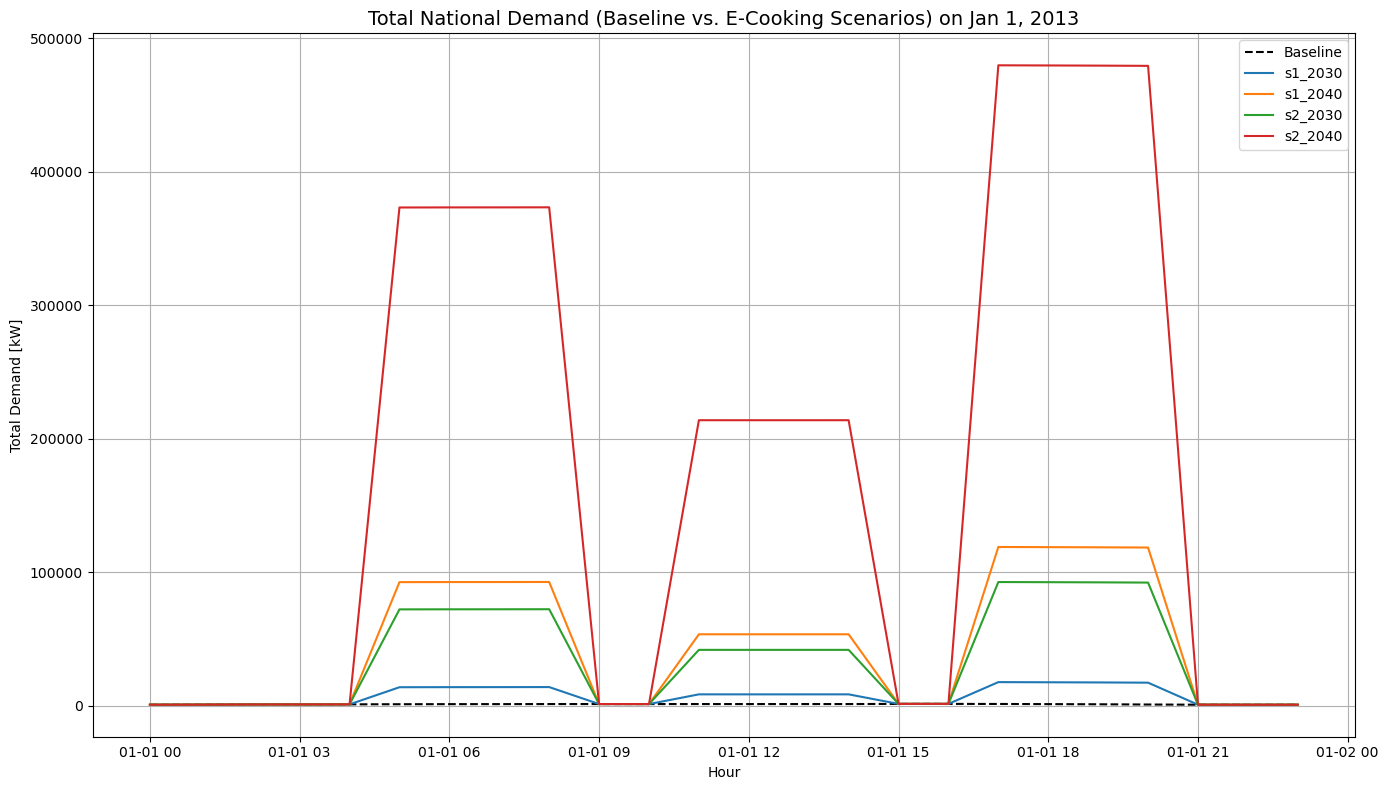

In [4]:
import matplotlib.pyplot as plt

# Load original (baseline) and one scenario for comparison
baseline = df_demand.copy()
scenario = pd.read_csv("C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/adjusted_demand_s1_2030.csv", parse_dates=['time']).set_index('time')



# Load baseline demand and calculate total across all buses
baseline = pd.read_csv("C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/custom/demand_profiles - Copy.csv", parse_dates=['time'])
baseline.set_index('time', inplace=True)
baseline_total = baseline.sum(axis=1)

# Scenario files and labels
scenario_paths = {
    "s1_2030": "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/adjusted_demand_s1_2030.csv",
    "s1_2040": "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/adjusted_demand_s1_2040.csv",
    "s2_2030": "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/adjusted_demand_s2_2030.csv",
    "s2_2040": "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/adjusted_demand_s2_2040.csv",
}

# Prepare plot
plt.figure(figsize=(14, 8))
plt.plot(baseline_total["2013-01-01":"2013-01-01 23:00:00"], label="Baseline", linestyle='--', color='black')

# Plot each scenario
for label, path in scenario_paths.items():
    scenario = pd.read_csv(path, parse_dates=['time'])
    scenario.set_index('time', inplace=True)
    total_demand = scenario.sum(axis=1)
    plt.plot(total_demand["2013-01-01":"2013-01-01 23:00:00"], label=label)

# Formatting
plt.title("Total National Demand (Baseline vs. E-Cooking Scenarios) on Jan 1, 2013", fontsize=14)
plt.xlabel("Hour")
plt.ylabel("Total Demand [kW]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Demand script using era5 (aggregated for the country)

In [ ]:
import pandas as pd
import numpy as np

#files
demand_file = "C:/Users/hie/pe_tan/pypsa-earth/data/ssp2-2.6/2030/era5_2013/Custom demand_TZ 2030.csv.csv"


# Load baseline demand
df_demand = pd.read_csv(demand_file, parse_dates=["time"])
df_demand.set_index("time", inplace=True)
df_demand=


# National population targets
pop_2030 = 79837087
pop_2040 = 102778984
bus_region["weight_2030"] = bus_region["pop_per_bus"] * (pop_2030 / bus_region["pop_per_bus"].sum())
bus_region["weight_2040"] = bus_region["pop_per_bus"] * (pop_2040 / bus_region["pop_per_bus"].sum())

# E-cooking peak per household by adoption level
ecook_peak_by_adoption = {
    0.2: (16.07 * 0.9001) / 108,
    0.5: (33.89 * 0.9530) / 108,
    1.0: (67.29 * 0.9764) / 108
}

# Cooking hours profile
cooking_profile = {
    'morning': {'hours': [5, 6, 7, 8], 'fraction': 0.35},
    'lunch': {'hours': [11, 12, 13, 14], 'fraction': 0.20},
    'evening': {'hours': [17, 18, 19, 20], 'fraction': 0.45}
}

persons_per_hh = 4.6

def generate_adjusted_profile(year, adoption_rate):
    pop_col = "weight_2030" if year == 2030 else "weight_2040"
    total_households = bus_region[pop_col].sum() / persons_per_hh
    peak_kw_per_hh = ecook_peak_by_adoption[adoption_rate]
    total_peak_kw = total_households * adoption_rate * peak_kw_per_hh

    added_load = pd.Series(0.0, index=df_demand.index)

    # Add cooking load to relevant hours
    for period, val in cooking_profile.items():
        for hour in val["hours"]:
            mask = added_load.index.hour == hour
            added_load[mask] += total_peak_kw * val["fraction"] / len(val["hours"])

   

# Generate and store scenarios
scenarios = {
    "s1_2030": (2030, 0.2),
    "s1_2040": (2040, 0.5),
    "s2_2030": (2030, 0.5),
    "s2_2040": (2040, 1.0),
}

output_previews = {}

for name, (year, adoption) in scenarios.items():
    df_adj = generate_adjusted_profile(year, adoption)
    output_previews[name] = df_adj.copy()
    df_adj.to_csv(f"C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/era5_demand_{name}.csv")

output_previews["s1_2030"].iloc[0:24]  # Show first day as preview


Baseline demand profile

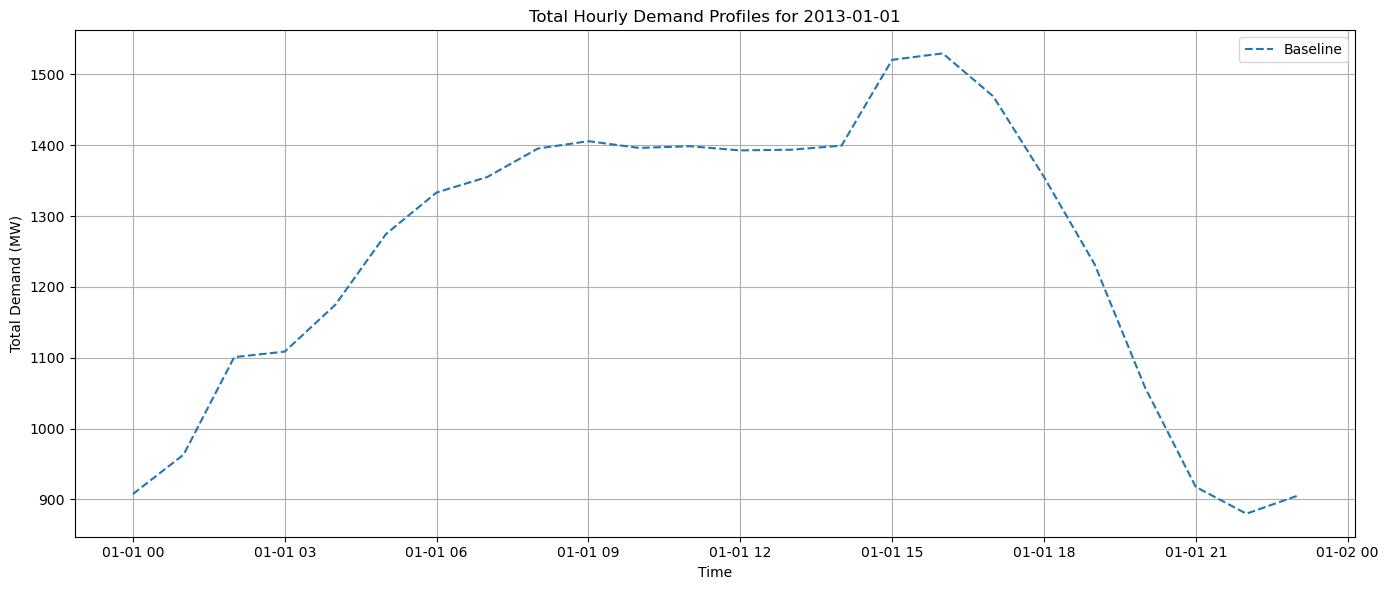

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
baseline_path = "demand_profiles - Copy.csv"

# Load all demand profiles
df_baseline = pd.read_csv(baseline_path, parse_dates=["time"]).set_index("time")

# Filter for one day (e.g., 2013-01-01)
df_baseline_one_day = df_baseline.loc["2013-01-01"]

# Aggregate total hourly demand
total_baseline = df_baseline_one_day.sum(axis=1)

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(total_baseline.index, total_baseline, label="Baseline", linestyle="--")

plt.title("Total Hourly Demand Profiles for 2013-01-01")
plt.xlabel("Time")
plt.ylabel("Total Demand (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Revised method using different ecooking input from "Modelling the Costs and Benefits of Modern Energy Cooking Services—Methods and Case Studies" NB! Normalized for 4.4 HH

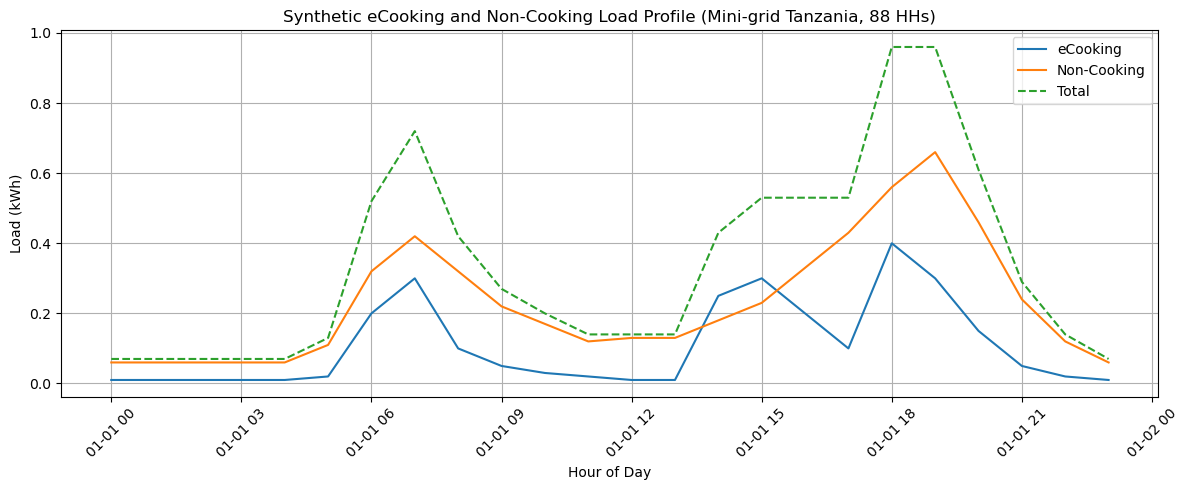

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


# Create time index (hourly)
time_index = [datetime(2023, 1, 1, h, 0) for h in range(24)]

# eCooking profile: based on 10 households with partial (50%) eCooking using EPCs
# Peak per household cooking load after diversity is 400W, which spans mainly around 3 meal windows.
ecooking_profile_watts = np.array([
    10, 10, 10, 10, 10, 20,    # 0-5
    200, 300, 100, 50, 30, 20, # 6-11 (breakfast/morning cooking peak)
    10, 10, 250, 300, 200, 100, # 12-17 (lunch/dinner ramp)
    400, 300, 150, 50, 20, 10  # 18-23 (dinner peak tapering)
])
ecooking_kwh = ecooking_profile_watts / 1000  # convert to kW (1-hour intervals)

# Non-cooking loads (lighting + appliances), from Figure 11 pattern, simplified
# Lighting: red line, generally stable and increasing after sunset
# Appliances: blue line, morning and evening peak
non_cooking_appliances = np.array([
    50, 50, 50, 50, 50, 100,   # 0-5
    300, 400, 300, 200, 150, 100,  # 6-11
    100, 100, 150, 200, 300, 400,  # 12-17
    500, 600, 400, 200, 100, 50   # 18-23
]) / 1000  # kWh

non_cooking_lighting = np.array([
    10, 10, 10, 10, 10, 10,  # 0-5
    20, 20, 20, 20, 20, 20,  # 6-11
    30, 30, 30, 30, 30, 30,  # 12-17
    60, 60, 60, 40, 20, 10   # 18-23
]) / 1000  # kWh

non_cooking_total_kwh = non_cooking_appliances + non_cooking_lighting

# Combine all into DataFrame
load_profile_df = pd.DataFrame({
    'Hour': time_index,
    'eCooking_kWh': ecooking_kwh,
    'NonCooking_kWh': non_cooking_total_kwh,
    'Total_kWh': ecooking_kwh + non_cooking_total_kwh
})

# Plot the profile
plt.figure(figsize=(12, 5))
plt.plot(load_profile_df['Hour'], load_profile_df['eCooking_kWh'], label='eCooking')
plt.plot(load_profile_df['Hour'], load_profile_df['NonCooking_kWh'], label='Non-Cooking')
plt.plot(load_profile_df['Hour'], load_profile_df['Total_kWh'], label='Total', linestyle='--')
plt.title('Synthetic eCooking and Non-Cooking Load Profile (Mini-grid Tanzania, 88 HHs)')
plt.ylabel('Load (kWh)')
plt.xlabel('Hour of Day')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




Transmission Impact Analysis Script - run when you actually how a decent profile

In [ ]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
import os

# === CONFIGURATION ===
network_path = "C:/Users/hie/pe_tan/pypsa-earth/results/networks/elec_s_all_ec_lcopt_1h.nc"
scenario_files = {
    "Baseline (2013)": "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/custom/demand_profiles - Copy.csv",
    "S1-2030 (20%)": "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/adjusted_demand_s1_2030.csv",
    "S1-2040 (50%)": "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/adjusted_demand_s1_2040.csv",
    "S2-2030 (50%)": "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/adjusted_demand_s2_2030.csv",
    "S2-2040 (100%)": "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/adjusted_demand_s2_2040.csv"
}
output_dir = "C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/transmission_analysis"
os.makedirs(output_dir, exist_ok=True)

# === FUNCTIONS ===
def update_demand_profile(network, demand_df):
    """Replaces the load profile in the PyPSA network."""
    network.loads_t.p = demand_df

def analyze_transmission_impact(network, label):
    """Runs LOPF and returns key metrics."""
    network.lopf(network.snapshots)
    line_loading = network.lines_t.p0.abs().div(network.lines.s_nom, axis=0)
    max_loading = line_loading.max().max()
    lost_load = network.loads_t.p.sum(axis=1).clip(upper=0).sum()
    return max_loading, lost_load

def plot_power_flow(network, label):
    """Generates and saves power flow plot."""
    fig_path = os.path.join(output_dir, f"power_flow_{label.replace(' ', '_')}.png")
    network.plot(
        line_colors=network.lines_t.p0.mean(axis=0),
        line_widths=2.0,
        bus_sizes=2.0,
        title=f"Power Flow: {label}",
        filename=fig_path,
        color_geomap=True,
        geomap=True
    )
    print(f"Saved power flow plot for {label} to: {fig_path}")

# === MAIN LOOP ===
results = []

for label, file_path in scenario_files.items():
    print(f"/n🔄 Processing: {label}")
    n = pypsa.Network(network_path)
    df = pd.read_csv(file_path, parse_dates=["time"]).set_index("time")
    update_demand_profile(n, df)

    max_loading, lost_load = analyze_transmission_impact(n, label)
    results.append({"Scenario": label, "Max Line Loading": max_loading, "Lost Load (MW)": lost_load})

    plot_power_flow(n, label)

# === SAVE SUMMARY ===
results_df = pd.DataFrame(results)
summary_path = os.path.join(output_dir, "transmission_summary.csv")
results_df.to_csv(summary_path, index=False)
print(f"/n📊 Transmission analysis summary saved to: {summary_path}")
print(results_df)



🔄 Processing: Baseline (2013)


INFO:pypsa.io:Imported network elec_s_all_ec_lcopt_1h.nc has buses, carriers, generators, lines, links, loads, storage_units, stores
C:\Users\hie\AppData\Local\Temp\ipykernel_19552\182602103.py:25: DeprecatedWarning:

lopf is deprecated as of 0.24 and will be removed in 1.0. Use linopy-based function ``n.optimize()`` instead. Migrate extra functionalities: https://pypsa.readthedocs.io/en/latest/examples/optimization-with-linopy-migrate-extra-functionalities.html.

INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 47.95s
INFO:pypsa.linopf:Solve linear problem using Glpk solver


: 

: 